In [46]:
import os
import glob
import cv2
import math
import itertools

import numpy as np
from datetime import datetime
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix

from keras.preprocessing import image
from keras import backend
from keras.models import Sequential, Model
from keras.utils import np_utils
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.layers import Conv2D, Input, concatenate
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions, preprocess_input, _obtain_input_shape
from keras.applications import InceptionV3

from keras.utils.data_utils import get_file

import pandas as pd

In [54]:
class DriverDistractionHelper:
    
    def __init__(self, img_rows, img_cols, color_type=1):
        pass
#         x_train, y_train, driver_id, unique_drivers = self.read_and_normalize_train_data(img_rows, img_cols, color_type)
#         x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, shuffle=True)
        
#         x_manual_tests = self.read_and_normalize_manual_test_data(120, 160, color_type)
        
#         self.x_train = x_train
#         self.y_train = y_train
#         self.x_test = x_test
#         self.y_test = y_test
        
#         self.x_manual_tests = x_manual_tests
    
    def read_and_normalize_train_data(self, img_rows, img_cols, color_type):
        x_train, y_train, driver_id, unique_drivers = self.load_train(img_rows, img_cols, color_type)
        x_train = np.array(x_train, dtype=np.uint8)
        y_train = np.array(y_train, dtype=np.uint8)
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, color_type)
        y_train = np_utils.to_categorical(y_train, 10)
        
        print('Train shape:', x_train.shape)
        print(x_train.shape[0], 'train samples')
        return x_train, y_train, driver_id, unique_drivers
    
    def read_and_normalize_test_data(self, begin_index, img_rows, img_cols, color_type=1, count=1000):
        test_data, test_ids = self.load_test(begin_index, img_rows, img_cols, color_type, count)

        test_data = np.array(test_data, dtype=np.uint8)
        test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, color_type)
        
        print('Test shape:', test_data.shape)
        print(test_data.shape[0], 'test samples')
        return test_data, test_ids
    
    def load_train(self, img_rows, img_cols, color_type=1):
        X_train = []
        y_train = []
        driver_id = []

        driver_data = self.get_driver_data()

        print('Read train images')
        for j in range(10):
            print('Load folder c{}'.format(j))
            path = os.path.join('..', 'input', 'train', 'c' + str(j), '*.jpg')
            files = glob.glob(path)
            for fl in files:
                flbase = os.path.basename(fl)
                img = self.get_image(fl, img_rows, img_cols, color_type)
                X_train.append(img)
                y_train.append(j)
                driver_id.append(driver_data[flbase])

        unique_drivers = sorted(list(set(driver_id)))
        print('Unique drivers: {}'.format(len(unique_drivers)))
        print(unique_drivers)
        return X_train, y_train, driver_id, unique_drivers
    
    def load_test(self, begin_index, img_rows, img_cols, color_type=1, count=1000):
        print('Read manual test images')
        path = os.path.join('..', 'input', 'test', '*.jpg')
        files = sorted(glob.glob(path))
        
        if(len(files)-count < begin_index):
            files = files[begin_index : len(files)]
        else:
            files = files[begin_index : begin_index+count]

        X_test = []
        X_test_id = []
        total = 0
        for fl in files:
            flbase = os.path.basename(fl)
            img = self.get_image(fl, img_rows, img_cols, color_type)
            X_test.append(img)
            X_test_id.append(flbase)
            total += 1
        return X_test, X_test_id
    
    def cache_data(self, data, path):
        if os.path.isdir(os.path.dirname(path)):
            file = open(path, 'wb')
            pickle.dump(data, file)
            file.close()
        else:
            print('Directory doesnt exists')
    
    def get_driver_data(self):
        dr = dict()
        path = os.path.join('..', 'input', 'driver_imgs_list.csv')
        print('Read drivers data')
        f = open(path, 'r')
        line = f.readline()
        while (1):
            line = f.readline()
            if line == '':
                break
            arr = line.strip().split(',')
            dr[arr[2]] = arr[0]
        f.close()
        return dr
    
    def get_image(self, path, img_rows, img_cols, color_type=1):        
        # Load as grayscale
        if color_type == 1:
            img = image.load_img(path, grayscale=True, target_size=(img_rows, img_cols))
        elif color_type == 3:
            img = image.load_img(path, target_size=(img_rows, img_cols))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = self.preprocess_input(img)
        
        return img

    def preprocess_input(self, img):
        img /= 255.
        img -= 0.5
        img *= 2.
        return img

In [3]:
def conv2d_bn(x, nb_filter, nb_row, nb_col,
              padding='same', subsample=(1, 1),
              name=None):
    """
    Utility function to apply conv + BN for Inception V3.
    """
    if name is not None:
        bn_name = name + '_bn'
        conv_name = name + '_conv'
    else:
        bn_name = None
        conv_name = None
    bn_axis = 3
    x = Conv2D(nb_filter, (nb_row, nb_col),
                      strides=subsample,
                      activation='relu',
                      padding=padding,
                      name=conv_name, 
                      data_format='channels_last')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name)(x)
    return x

def create_model(img_rows, img_cols, color_type=1, num_classes=10):
    channel_axis = 3
    img_input = Input(shape=(img_rows, img_cols, color_type))
    x = conv2d_bn(img_input, 32, 3, 3, subsample=(2, 2), padding='valid')
    x = conv2d_bn(x, 32, 3, 3, padding='valid')
    x = conv2d_bn(x, 64, 3, 3)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv2d_bn(x, 80, 1, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, 3, padding='valid')
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # mixed 0, 1, 2: 35 x 35 x 256
    for i in range(3):
        branch1x1 = conv2d_bn(x, 64, 1, 1)

        branch5x5 = conv2d_bn(x, 48, 1, 1)
        branch5x5 = conv2d_bn(branch5x5, 64, 5, 5)

        branch3x3dbl = conv2d_bn(x, 64, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 32, 1, 1)
        x = concatenate([branch1x1, branch5x5, branch3x3dbl, branch_pool],
                  axis=channel_axis,
                  name='mixed' + str(i))

    # mixed 3: 17 x 17 x 768
    branch3x3 = conv2d_bn(x, 384, 3, 3, subsample=(2, 2), padding='valid')

    branch3x3dbl = conv2d_bn(x, 64, 1, 1)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3)
    branch3x3dbl = conv2d_bn(branch3x3dbl, 96, 3, 3,
                             subsample=(2, 2), padding='valid')

    branch_pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch3x3dbl, branch_pool],
              axis=channel_axis,
              name='mixed3')

    # mixed 4: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 128, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 128, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 128, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 128, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              axis=channel_axis,
              name='mixed4')

    # mixed 5, 6: 17 x 17 x 768
    for i in range(2):
        branch1x1 = conv2d_bn(x, 192, 1, 1)

        branch7x7 = conv2d_bn(x, 160, 1, 1)
        branch7x7 = conv2d_bn(branch7x7, 160, 1, 7)
        branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

        branch7x7dbl = conv2d_bn(x, 160, 1, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 1, 7)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 160, 7, 1)
        branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
                  axis=channel_axis,
                  name='mixed' + str(5 + i))

    # mixed 7: 17 x 17 x 768
    branch1x1 = conv2d_bn(x, 192, 1, 1)

    branch7x7 = conv2d_bn(x, 192, 1, 1)
    branch7x7 = conv2d_bn(branch7x7, 192, 1, 7)
    branch7x7 = conv2d_bn(branch7x7, 192, 7, 1)

    branch7x7dbl = conv2d_bn(x, 160, 1, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 7, 1)
    branch7x7dbl = conv2d_bn(branch7x7dbl, 192, 1, 7)

    branch_pool = AveragePooling2D((3, 3), strides=(1, 1), padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
    x = concatenate([branch1x1, branch7x7, branch7x7dbl, branch_pool],
              axis=channel_axis,
              name='mixed7')

    # mixed 8: 8 x 8 x 1280
    branch3x3 = conv2d_bn(x, 192, 1, 1, subsample=(1, 1), padding='same')
    branch3x3 = conv2d_bn(branch3x3, 320, 3, 3,
                          subsample=(2, 2), padding='valid')

    branch7x7x3 = conv2d_bn(x, 192, 1, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 1, 7)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 7, 1)
    branch7x7x3 = conv2d_bn(branch7x7x3, 192, 3, 3,
                            subsample=(2, 2), padding='valid')

    branch_pool = AveragePooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([branch3x3, branch7x7x3, branch_pool],
              axis=channel_axis,
              name='mixed8')

    # mixed 9: 8 x 8 x 2048
    for i in range(2):
        branch1x1 = conv2d_bn(x, 320, 1, 1)

        branch3x3 = conv2d_bn(x, 384, 1, 1)
        branch3x3_1 = conv2d_bn(branch3x3, 384, 1, 3)
        branch3x3_2 = conv2d_bn(branch3x3, 384, 3, 1)
        branch3x3 = concatenate([branch3x3_1, branch3x3_2],
                          axis=channel_axis,
                          name='mixed9_' + str(i))

        branch3x3dbl = conv2d_bn(x, 448, 1, 1)
        branch3x3dbl = conv2d_bn(branch3x3dbl, 384, 3, 3)
        branch3x3dbl_1 = conv2d_bn(branch3x3dbl, 384, 1, 3)
        branch3x3dbl_2 = conv2d_bn(branch3x3dbl, 384, 3, 1)
        branch3x3dbl = concatenate([branch3x3dbl_1, branch3x3dbl_2],
                             axis=channel_axis)

        branch_pool = AveragePooling2D(
            (3, 3), strides=(1, 1), padding='same')(x)
        branch_pool = conv2d_bn(branch_pool, 192, 1, 1)
        x = concatenate([branch1x1, branch3x3, branch3x3dbl, branch_pool],
                  axis=channel_axis,
                  name='mixed' + str(9 + i))

    # Fully Connected Softmax Layer
    x_fc = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
    x_fc = Flatten(name='flatten')(x_fc)
    x_fc = Dense(1000, activation='softmax', name='predictions')(x_fc)

    # Create model
    model = Model(img_input, x_fc)

    # Load ImageNet pre-trained data 
    model.load_weights('models/inception_v3_weights_tf_dim_ordering_tf_kernels.h5')

    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    x_newfc = AveragePooling2D((8, 8), strides=(8, 8), name='avg_pool')(x)
    x_newfc = Flatten(name='flatten')(x_newfc)
    x_newfc = Dense(num_classes, activation='softmax', name='predictions')(x_newfc)

    # Create another model with our customized softmax
    model = Model(img_input, x_newfc)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

    return model 

In [4]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
img_rows = 299
img_cols = 299
color_type = 3

batch_size = 32
nb_epoch = 4
random_state = 51

In [10]:
ddh = DriverDistractionHelper(img_rows, img_cols, color_type)

Read drivers data
Read train images
Load folder c0
Load folder c1
Load folder c2
Load folder c3
Load folder c4
Load folder c5
Load folder c6
Load folder c7
Load folder c8
Load folder c9
Unique drivers: 26
['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']
('Train shape:', (22424, 299, 299, 3))
(22424, 'train samples')


In [17]:
model = create_model(img_rows, img_cols, color_type)
# model = create_model_keras(300, 300, color_type)

In [18]:
time_before_training = datetime.now()
model.fit(ddh.x_train, ddh.y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(ddh.x_test, ddh.y_test))
time_after_training = datetime.now()

Train on 17939 samples, validate on 4485 samples
Epoch 1/4
17939/17939 [==============================] - 14017s 781ms/step - loss: 0.9774 - acc: 0.6756 - val_loss: 0.2359 - val_acc: 0.9315
Epoch 2/4
17939/17939 [==============================] - 14003s 781ms/step - loss: 0.0842 - acc: 0.9788 - val_loss: 0.1354 - val_acc: 0.9567
Epoch 3/4
17939/17939 [==============================] - 14000s 780ms/step - loss: 0.0177 - acc: 0.9970 - val_loss: 0.0726 - val_acc: 0.9784
Epoch 4/4
17939/17939 [==============================] - 13970s 779ms/step - loss: 0.0070 - acc: 0.9994 - val_loss: 0.0574 - val_acc: 0.9842


In [19]:
time_before_pred = datetime.now()
predictions_valid = model.predict(ddh.x_test, batch_size=128, verbose=1)
time_after_pred = datetime.now()

4485/4485 [==============================] - 1153s 257ms/step


In [20]:
training_time = time_after_training - time_before_training
training_time = training_time.total_seconds()

In [21]:
pred_time = time_after_pred - time_before_pred
pred_time_avg = (pred_time.total_seconds()*1000)/len(ddh.x_test)

In [22]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    pure_y_valid = backend.argmax(ddh.y_test)
    pure_y_pred = backend.argmax(predictions_valid)

    
    pure_y_valid = sess.run(pure_y_valid)
    pure_y_pred = sess.run(pure_y_pred)

In [23]:
y_comp = [1 if i==j else 0 for i,j in zip(pure_y_pred, pure_y_valid)]
accuracy = np.mean(y_comp)

In [24]:
print 'Accuracy: ', accuracy
print 'Training Time: ', training_time
print 'Average Time to Classify a Image: ', pred_time_avg

Accuracy:  0.984169453735
Training Time:  55996.696352
Average Time to Classify a Image:  257.074264883


In [25]:
cm = confusion_matrix(pure_y_valid, pure_y_pred)

In [26]:
classes = ['safe driving', 'texting - right', 'talking on the phone - right', 'exting - left', 'talking on the phone - left',
          'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger']
keys = ['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

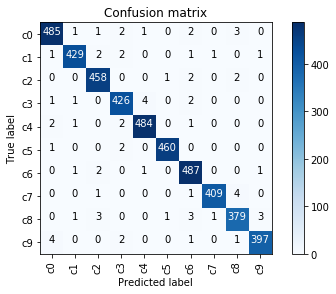

In [27]:
plot_confusion_matrix(cm, keys, normalize=False)

In [28]:
#for i in range(100):
#    img_brute = ddh.x_manual_tests[i]
#    img = img_brute.transpose(1, 2, 0)
#    img = cv2.resize(img, (img_cols, img_rows))
#    img = img.reshape(1, 1, img_rows, img_cols)
#    predicted = model.predict_classes(img)
        
#    plt.figure()
#    plt.title(predicted)
#    plt.imshow(img_brute.reshape(120, 160), cmap='gray')

In [29]:
model.save('models/InceptionV3_model.h5')
model.save_weights('models/InceptionV3_model_weights.h5')

In [58]:
def test_model_and_generate_submission(model, driver_distraction_helper, img_rows, img_cols, color_type):
    test_imgs, test_ids = driver_distraction_helper.read_and_normalize_test_data(0, img_rows, img_cols, color_type, 1000)

    predictions = model.predict(test_imgs, batch_size=128, verbose=1)
    
    general_result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    general_result.loc[:, 'img'] = pd.Series(test_ids, index=general_result.index)
    
    for i in range(80):
        test_imgs, test_ids = driver_distraction_helper.read_and_normalize_test_data(((i+1)*1000), img_rows, img_cols, color_type)

        predictions = model.predict(test_imgs, batch_size=128, verbose=1)
        
        result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
        result.loc[:, 'img'] = pd.Series(test_ids, index=result.index)
        
        general_result = general_result.append(result, ignore_index=True)
        
    now = datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = '_at_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    general_result.to_csv(sub_file, index=False, float_format='%.10f')  

In [59]:
ddh2 = DriverDistractionHelper(img_rows, img_cols, color_type)

In [60]:
test_model_and_generate_submission(model, ddh2, img_rows, img_cols, color_type)

Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 259s 259ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 257s 257ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 257s 257ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 257s 257ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 257s 257ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 257s 257ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 2

1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, 'test samples')
1000/1000 [==============================] - 258s 258ms/step
Read manual test images
('Test shape:', (1000, 299, 299, 3))
(1000, '

In [52]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size, class_id):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
        class_id: class_id
    # Returns
        Image as numpy array.
    """
    if train_or_test == 'train':
        img = image.load_img(os.path.join('../input', train_or_test, '%s' % class_id, '%s' % img_id), target_size=size)
    else :
        img = image.load_img(os.path.join('../input', train_or_test, '%s' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [53]:
print('Start testing............')
test = pd.read_csv('../input/sample_submission.csv')
test_labels = test.reset_index()
print(len(test))

with open('submission_InceptionV3_t2.csv','wb') as file:
    file.write('img,'+'c0,c1,c2,c3,c4,c5,c6,c7,c8,c9')
    file.write('\n')

    #x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32') #xx images with 224X224X3
    for i, index in enumerate(test_labels['index']):
        img_name = test_labels.img[i]
        classname = 'c0'
        img = read_img(img_name, 'test', (img_rows, img_cols), classname)
        x = preprocess_input(np.expand_dims(img.copy(), axis=0))
        #x_test[i] = x
        print i
        test_prediction = model.predict(x, batch_size=128, verbose=1)
        file.write(img_name+','+str(test_prediction[0][0])+','+str(test_prediction[0][1])+','+str(test_prediction[0][2])+','+str(test_prediction[0][3])
                  +','+str(test_prediction[0][4])+','+str(test_prediction[0][5])+','+str(test_prediction[0][6])+','+str(test_prediction[0][7])
                  +','+str(test_prediction[0][8])+','+str(test_prediction[0][9]))
        file.write('\n')
        
        if i == 20:
            break

    #print('Test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))
file.close()

Start testing............
79726
0
1/1 [==============================] - 0s 256ms/step
1
1/1 [==============================] - 0s 191ms/step
2
1/1 [==============================] - 0s 200ms/step
3
1/1 [==============================] - 0s 192ms/step
4
1/1 [==============================] - 0s 191ms/step
5
1/1 [==============================] - 0s 190ms/step
6
1/1 [==============================] - 0s 195ms/step
7
1/1 [==============================] - 0s 189ms/step
8
1/1 [==============================] - 0s 187ms/step
9
1/1 [==============================] - 0s 191ms/step
10
1/1 [==============================] - 0s 189ms/step
11
1/1 [==============================] - 0s 256ms/step
12
1/1 [==============================] - 0s 256ms/step
13
1/1 [==============================] - 0s 262ms/step
14
1/1 [==============================] - 0s 256ms/step
15
1/1 [==============================] - 0s 262ms/step
16
1/1 [==============================] - 0s 261ms/step
17
1/1 [==================